# Neural ratio estimation

This tutorial demonstrates how to perform neural ratio estimation (NRE) with LAMPE.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import zuko

from itertools import islice
from lampe.data import JointLoader
from lampe.inference import NRE, MetropolisHastings, NRELoss
from lampe.plots import corner, mark_point, nice_rc
from lampe.utils import GDStep
from tqdm import trange

## Simulator

In [2]:
LABELS = [r'$\theta_1$', r'$\theta_2$', r'$\theta_3$']
LOWER = -torch.ones(3)
UPPER = torch.ones(3)

prior = zuko.distributions.BoxUniform(LOWER, UPPER)

def simulator(theta: torch.Tensor) -> torch.Tensor:
    x = torch.stack([
        theta[..., 0] + theta[..., 1] * theta[..., 2],
        theta[..., 0] * theta[..., 1] + theta[..., 2],
    ], dim=-1)

    return x + 0.05 * torch.randn_like(x)

theta = prior.sample()
x = simulator(theta)

print(theta, x, sep='\n')

tensor([0.7469, 0.2132, 0.2058])
tensor([0.7496, 0.3736])


In [3]:
loader = JointLoader(prior, simulator, batch_size=256, vectorized=True)

## Training

The principle of neural ratio estimation (NRE) is to train a classifier network $d_\phi(\theta, x)$ to distinguish between pairs $(\theta, x)$ equally sampled from the joint distribution $p(\theta, x)$ or from the product of the marginals $p(\theta) p(x)$. We use the [`NRE`](lampe.inference.nre.NRE) class to create a classifier network adapted to the simulator's input and output sizes. For numerical stability reasons, the created network returns the logit of the class prediction $\text{logit}(d_\phi(\theta, x)) = \log r_\phi(\theta, x)$.

In [4]:
estimator = NRE(3, 2, hidden_features=[64] * 5, activation=nn.ELU)
estimator

NRE(
  (net): MLP(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
)

Then, we train our classifier using a standard neural network training routine.

In [5]:
loss = NRELoss(estimator)
optimizer = optim.Adam(estimator.parameters(), lr=1e-3)
step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping

estimator.train()

for epoch in (bar := trange(128, unit='epoch')):
    losses = []

    for theta, x in islice(loader, 256):  # 256 batches per epoch
        losses.append(step(loss(theta, x)))

    bar.set_postfix(loss=torch.stack(losses).mean().item())

100%|██████████| 128/128 [01:28<00:00,  1.45epoch/s, loss=0.0462]


## Inference

Now that we have an estimator of the likelihood-to-evidence (LTE) ratio $r(\theta, x) = \frac{p(\theta | x)}{p(\theta)}$, we can sample from the posterior distribution of an observation $x^*$ via MCMC or nested sampling. In our case, we use the [`MetropolisHastings`](lampe.inference.mcmc.MetropolisHastings) sampler.

In [6]:
theta_star = prior.sample()
x_star = simulator(theta_star)

estimator.eval()

with torch.no_grad():
    # 1024 concurrent Markov chains
    theta_0 = prior.sample((1024,))
    # p(theta | x) = r(theta, x) p(theta)
    log_p = lambda theta: estimator(theta, x_star) + prior.log_prob(theta)

    sampler = MetropolisHastings(theta_0, log_f=log_p, sigma=0.5)
    samples = torch.cat(list(sampler(2048, burn=1024, step=4)))

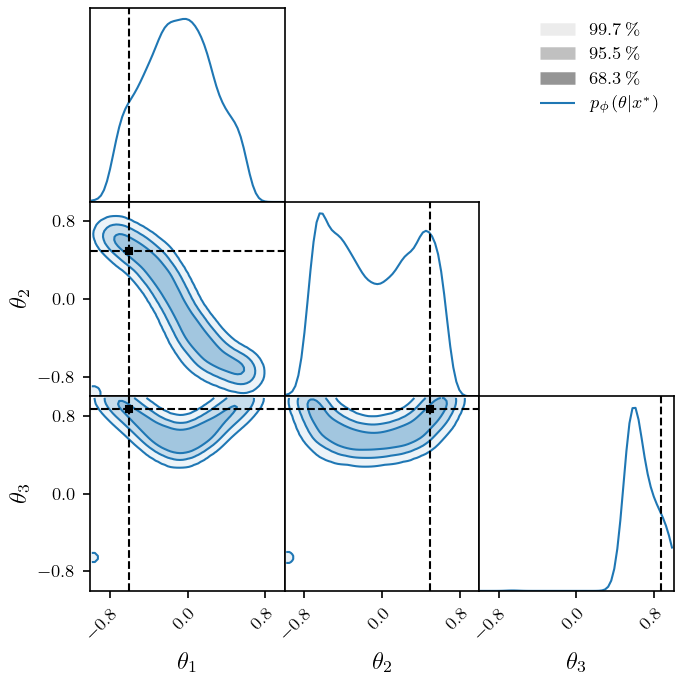

In [7]:
plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

fig = corner(
    samples,
    smooth=2,
    domain=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_\phi(\theta | x^*)$',
    figsize=(4.8, 4.8),
)

mark_point(fig, theta_star)